In [108]:
import os
import numpy as np
import pandas as pd
import pandas_profiling

import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as sn
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

In [109]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

In [110]:
#Importing data
credit=pd.read_excel("D:/Analytix labs/Assignments & Case Studies/Final Projects/1. Predicting Credit Card Spend & Identifying Key Drivers/Data Set.xlsx")

In [111]:
credit.head()

,custid,region,townsize,gender,age,agecat,birthmonth,ed,edcat,jobcat,...,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
0,3964-QJWTRG-NPN,1,2.0,1,20,2,September,15,3,1,...,0,0,0,1,1,0,0,0,1,0
1,0648-AIPJSP-UVM,5,5.0,0,22,2,May,17,4,2,...,1,1,1,1,1,1,1,0,0,0
2,5195-TLUDJE-HVO,3,4.0,1,67,6,June,14,2,2,...,1,0,0,0,0,0,1,0,0,0
3,4459-VLPQUH-3OL,4,3.0,0,23,2,May,16,3,2,...,1,0,1,1,1,0,1,1,0,0
4,8158-SMTQFB-CNO,2,2.0,0,26,3,July,16,3,2,...,1,0,1,0,1,0,0,0,1,0


# Making Y by adding two variables

In [112]:
#To create Y we need to sumup cardspent(first card spent amount) and card2spent(Second card spent amount)
credit['totalspend'] = credit['cardspent'] + credit['card2spent']

In [113]:
print(credit.info())
print(credit.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 131 entries, custid to totalspend
dtypes: float64(32), int64(97), object(2)
memory usage: 5.0+ MB
None
(5000, 131)


#  dropping the columns that used to make Y variable

In [114]:
#Drop cardspent(first card spent amount) and card2spent(Second card spent amount) because its not adding any value
credit.drop(["cardspent","card2spent","custid"],axis=1, inplace=True)

In [115]:
# Creating List which Contains categorical variables
for x in ['region','townsize','gender','agecat','edcat','birthmonth','jobcat','union','employ','empcat','retire',
          'inccat','default','jobsat','marital','spousedcat','homeown','hometype','address','addresscat','cars','carown',
          'cartype','carcatvalue','carbought','carbuy','commute','commutecat','commutecar',
          'commutemotorcycle','commutecarpool','commutebus','commuterail','commutepublic','commutebike','commutewalk',
         'commutenonmotor','telecommute','reason','polview','polparty','polcontrib','vote','card','cardtype','cardbenefit',
         'cardfee','cardtenure','cardtenurecat','card2','card2type','card2benefit','card2fee','card2tenure','card2tenurecat',
         'active','bfast','churn','tollfree','equip','callcard','wireless','multline','voice','pager','internet','callid',
         'callwait','forward','confer','ebill','owntv','ownvcr','owndvd','owncd','ownpda','ownpc','ownipod','owngame','ownfax',
        'news','response_01','response_02','response_03']:
    credit[x]=credit[x].astype('object')

# Seperating numerical and categorical data

In [116]:
numeric_var_list=[key for key in dict(credit.dtypes) if dict(credit.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]

cat_var_list=[key for key in dict(credit.dtypes) if dict(credit.dtypes)[key] in ['object']]
print(numeric_var_list)
print(cat_var_list)

['age', 'ed', 'income', 'lninc', 'debtinc', 'creddebt', 'lncreddebt', 'othdebt', 'lnothdebt', 'spoused', 'reside', 'pets', 'pets_cats', 'pets_dogs', 'pets_birds', 'pets_reptiles', 'pets_small', 'pets_saltfish', 'pets_freshfish', 'carvalue', 'commutetime', 'tenure', 'longmon', 'lnlongmon', 'longten', 'lnlongten', 'tollmon', 'lntollmon', 'tollten', 'lntollten', 'equipmon', 'lnequipmon', 'equipten', 'lnequipten', 'cardmon', 'lncardmon', 'cardten', 'lncardten', 'wiremon', 'lnwiremon', 'wireten', 'lnwireten', 'hourstv', 'totalspend']
['region', 'townsize', 'gender', 'agecat', 'birthmonth', 'edcat', 'jobcat', 'union', 'employ', 'empcat', 'retire', 'inccat', 'default', 'jobsat', 'marital', 'spousedcat', 'homeown', 'hometype', 'address', 'addresscat', 'cars', 'carown', 'cartype', 'carcatvalue', 'carbought', 'carbuy', 'commute', 'commutecat', 'commutecar', 'commutemotorcycle', 'commutecarpool', 'commutebus', 'commuterail', 'commutepublic', 'commutebike', 'commutewalk', 'commutenonmotor', 'telec

In [117]:
credit_num = credit[numeric_var_list]

In [118]:
credit_num.head()

,age,ed,income,lninc,debtinc,creddebt,lncreddebt,othdebt,lnothdebt,spoused,...,cardmon,lncardmon,cardten,lncardten,wiremon,lnwiremon,wireten,lnwireten,hourstv,totalspend
0,20,15,31,3.433987,11.1,1.200909,0.183079,2.240091,0.806516,-1,...,14.25,2.656757,60.0,4.094345,0.00,NaN,0.00,NaN,13,149.46
1,22,17,15,2.708050,18.6,1.222020,0.200505,1.567980,0.449788,-1,...,16.00,2.772589,610.0,6.413459,45.65,3.821004,1683.55,7.428660,18,77.54
2,67,14,35,3.555348,9.9,0.928620,-0.074056,2.536380,0.930738,13,...,23.00,3.135494,1410.0,7.251345,0.00,NaN,0.00,NaN,21,359.97
3,23,16,20,2.995732,5.7,0.022800,-3.780995,1.117200,0.110826,18,...,21.00,3.044522,685.0,6.529419,0.00,NaN,0.00,NaN,26,359.41
4,26,16,23,3.135494,1.7,0.214659,-1.538705,0.176341,-1.735336,13,...,17.25,2.847812,360.0,5.886104,19.05,2.947067,410.80,6.018106,27,507.83


In [119]:
credit_cat = credit[cat_var_list]

In [120]:
# Use a general function that returns multiple values
def var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), x.var(), x.min(), x.dropna().quantile(0.01), x.dropna().quantile(0.05),x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75), x.dropna().quantile(0.90),x.dropna().quantile(0.95), x.dropna().quantile(0.99),x.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

num_summary=credit_num.apply(lambda x: var_summary(x)).T

In [121]:
num_summary

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
age,5000.0,0.0,2.351280e+05,47.025600,47.000000,17.770338,3.157849e+02,18.000000,18.000000,20.000000,23.000000,31.000000,47.000000,62.000000,72.000000,76.000000,79.000000,79.000000
ed,5000.0,0.0,7.271500e+04,14.543000,14.000000,3.281083,1.076550e+01,6.000000,8.000000,9.000000,10.000000,12.000000,14.000000,17.000000,19.000000,20.000000,21.000000,23.000000
income,5000.0,0.0,2.737980e+05,54.759600,38.000000,55.377511,3.066669e+03,9.000000,9.000000,13.000000,16.000000,24.000000,38.000000,67.000000,109.100000,147.000000,272.010000,1073.000000
lninc,5000.0,0.0,1.849955e+04,3.699909,3.637586,0.747072,5.581164e-01,2.197225,2.197225,2.564949,2.772589,3.178054,3.637586,4.204693,4.692261,4.990433,5.605839,6.978214
debtinc,5000.0,0.0,4.977080e+04,9.954160,8.800000,6.399783,4.095723e+01,0.000000,0.700000,1.900000,2.800000,5.100000,8.800000,13.600000,18.600000,22.200000,29.200000,43.100000
creddebt,5000.0,0.0,9.286628e+03,1.857326,0.926437,3.415732,1.166722e+01,0.000000,0.033160,0.101088,0.175682,0.385520,0.926437,2.063820,4.299470,6.373010,14.280358,109.072596
lncreddebt,4999.0,1.0,-6.521372e+02,-0.130454,-0.076106,1.273058,1.620678e+00,-6.597334,-3.401690,-2.291604,-1.737842,-0.952685,-0.076106,0.724665,1.458625,1.852297,2.658910,4.692014
othdebt,5000.0,0.0,1.827230e+04,3.654460,2.098540,5.395172,2.910788e+01,0.000000,0.114299,0.287692,0.457997,0.980301,2.098540,4.314780,8.062046,11.815981,24.064260,141.459150
lnothdebt,4999.0,1.0,3.483879e+03,0.696915,0.741537,1.128578,1.273689e+00,-4.092107,-2.168241,-1.243483,-0.780312,-0.018987,0.741537,1.462053,2.087178,2.469586,3.180802,4.952011
spoused,5000.0,0.0,3.056400e+04,6.112800,-1.000000,7.743518,5.996207e+01,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,14.000000,16.000000,18.000000,20.000000,24.000000


In [122]:
def cat_summary(x):
    return pd.Series([x.count(),x.isnull().sum(),x.value_counts(),x.unique()],
                    index=['N','NMISS','ColumnNames','UniqueValues'])

In [123]:
cat_summary=credit_cat.apply(lambda x:cat_summary(x)).T
cat_summary

,N,NMISS,ColumnNames,UniqueValues
region,5000,0,5 1027 1 1009 3 1003 2 995 4 ...,"[1, 5, 3, 4, 2]"
townsize,4998,2,1.0 1436 2.0 1048 3.0 907 4.0 85...,"[2.0, 5.0, 4.0, 3.0, 1.0, nan]"
gender,5000,0,"1 2518 0 2482 Name: gender, dtype: int64","[1, 0]"
agecat,5000,0,4 1222 5 1195 6 1068 3 893 2 ...,"[2, 6, 3, 5, 4]"
birthmonth,5000,0,September 458 May 451 June ...,"[September, May, June, July, August, October, ..."
...,...,...,...,...
ownfax,5000,0,"0 4106 1 894 Name: ownfax, dtype: int64","[0, 1]"
news,5000,0,"0 2637 1 2363 Name: news, dtype: int64","[0, 1]"
response_01,5000,0,"0 4582 1 418 Name: response_01, dtype: ...","[0, 1]"
response_02,5000,0,"0 4351 1 649 Name: response_02, dtype: ...","[1, 0]"


# Outliers Treatment

In [124]:
def outlier_treatment(x):
    x=x.clip_upper(x.quantile(0.99))
    x=x.clip_lower(x.quantile(0.01))
    x=x.fillna(x.median())
    return x

In [125]:
credit_num = credit_num.apply(lambda x: outlier_treatment(x))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: clip_upper(threshold) is deprecated, use clip(upper=threshold) instead
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead
  This is separate from the ipykernel package so we can avoid doing imports until


# Missing value treatment in categorical data

In [126]:
#for categorical variable only missing value treatment

def missing_treatment(x):
    x=x.fillna(x.mode())
    return x

credit_cat = credit_cat.apply(lambda x: missing_treatment(x))

In [127]:
# checking for missing values
print ("Missing values in numerical data :  ", credit_num.isnull().sum().values.sum())
print ("Missing values in categorical data :  ", credit_cat.isnull().sum().values.sum())

Missing values in numerical data :   0
Missing values in categorical data :   2


# Creating dummy for categorical data

In [128]:
# We need to create a function for dummy creation
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname)
    col_dummies.drop(col_dummies.columns[0], axis = 1, inplace = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True)
    return df

In [129]:
credit_cat=credit.select_dtypes(include=['object'])
cat_varlist=list(credit_cat.columns)

In [130]:
# For customer_features in categorical features

for c_feature in cat_varlist:
    credit_cat[c_feature]=credit_cat[c_feature].astype('category')
    credit_cat=create_dummies(credit_cat,c_feature)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [131]:
credit_cat.head(5)

,region_2,region_3,region_4,region_5,townsize_2.0,townsize_3.0,townsize_4.0,townsize_5.0,gender_1,agecat_3,...,owncd_1,ownpda_1,ownpc_1,ownipod_1,owngame_1,ownfax_1,news_1,response_01_1,response_02_1,response_03_1
0,0,0,0,0,1,0,0,0,1,0,...,0,0,0,1,1,0,0,0,1,0
1,0,0,0,1,0,0,0,1,0,0,...,1,1,1,1,1,1,1,0,0,0
2,0,1,0,0,0,0,1,0,1,0,...,1,0,0,0,0,0,1,0,0,0
3,0,0,1,0,0,1,0,0,0,0,...,1,0,1,1,1,0,1,1,0,0
4,1,0,0,0,1,0,0,0,0,1,...,1,0,1,0,1,0,0,0,1,0


# Merge Numerical and categorical data

In [132]:
credit_num.shape

(5000, 44)

In [133]:
credit_cat.shape

(5000, 356)

In [134]:
credit_spend = pd.concat([credit_num, credit_cat], axis=1)

In [135]:
credit_spend

,age,ed,income,lninc,debtinc,creddebt,lncreddebt,othdebt,lnothdebt,spoused,...,owncd_1,ownpda_1,ownpc_1,ownipod_1,owngame_1,ownfax_1,news_1,response_01_1,response_02_1,response_03_1
0,20,15,31.0,3.433987,11.1,1.200909,0.183079,2.240091,0.806516,-1,...,0,0,0,1,1,0,0,0,1,0
1,22,17,15.0,2.708050,18.6,1.222020,0.200505,1.567980,0.449788,-1,...,1,1,1,1,1,1,1,0,0,0
2,67,14,35.0,3.555348,9.9,0.928620,-0.074056,2.536380,0.930738,13,...,1,0,0,0,0,0,1,0,0,0
3,23,16,20.0,2.995732,5.7,0.033160,-3.401690,1.117200,0.110826,18,...,1,0,1,1,1,0,1,1,0,0
4,26,16,23.0,3.135494,1.7,0.214659,-1.538705,0.176341,-1.735336,13,...,1,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,68,10,196.0,5.278115,8.0,7.934080,2.071167,7.745920,2.047166,-1,...,1,0,0,0,0,0,1,0,0,0
4996,51,14,83.0,4.418841,15.0,3.336600,1.204952,9.113400,2.209746,-1,...,1,0,0,0,0,0,0,0,0,0
4997,75,17,108.0,4.682131,10.8,3.557520,1.269064,8.106480,2.092664,-1,...,1,1,0,0,0,0,1,0,0,0
4998,47,19,189.0,5.241747,10.8,5.021352,1.613699,15.390648,2.733760,15,...,1,0,1,1,1,0,1,0,0,0


# - Dropping variables with high correlation

In [137]:
#dropping variable that has high correlation

credit_spend.drop(['cardten', 'lninc','lncreddebt','lnothdebt','lnlongmon','lnlongten','lntollmon','lntollten',
'lnequipmon','lnequipten','lncardten','lnwiremon','lnwireten'],axis=1, inplace=True)

# Explore data and check the variable distribution

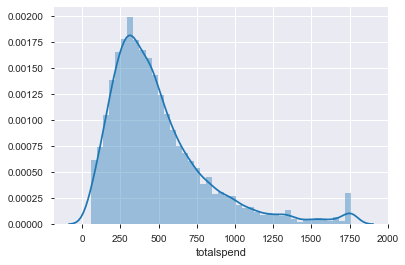

In [138]:
# checking whwther y(totalspend) should follow the normal distribution in linear regression
import seaborn as sns
sns.distplot(credit_spend.totalspend)
plt.show()

***distribution is right skewed so we need to take log and then plot the graph to make it normal distribution.***

In [139]:
from scipy import stats

# transform training data & save lambda value
credit_spend['total_spend'],fitted_lambda = stats.boxcox(credit_spend['totalspend'])

In [140]:
credit_spend['total_spend']

0        7.323447
1        6.039640
2        9.243615
3        9.239995
4       10.063778
          ...    
4995    12.781235
4996     9.284513
4997    12.978062
4998    11.053472
4999     9.536633
Name: total_spend, Length: 5000, dtype: float64

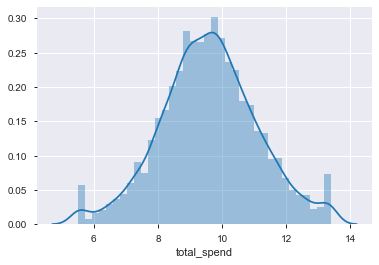

In [141]:
sns.distplot(credit_spend.total_spend)
plt.show()

# Drop the y variables(totalspend) from dataframe because we are looking correlation between all x variables

In [142]:
credit_spend.drop(['totalspend'],axis=1,inplace=True)

# Splitting data into train and test

In [143]:
feature_columns=credit_spend.columns.difference(['total_spend'])

In [144]:
feature_columns

Index(['active_1', 'address_1', 'address_10', 'address_11', 'address_12',
       'address_13', 'address_14', 'address_15', 'address_16', 'address_17',
       ...
       'townsize_2.0', 'townsize_3.0', 'townsize_4.0', 'townsize_5.0',
       'union_1', 'voice_1', 'vote_1', 'wireless_1', 'wiremon', 'wireten'],
      dtype='object', length=386)

In [145]:
from sklearn.model_selection import train_test_split

train_x,test_x,train_y,test_y=train_test_split(credit_spend[feature_columns],
                                              credit_spend['total_spend'],
                                              test_size=0.2,
                                              random_state=12)

In [146]:
print (len(train_x))
print (len(test_x))
print (len(train_y))
print (len(test_y))

4000
1000
4000
1000


# Feature selection

 - random Forest

In [147]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [148]:
param_grid={'n_estimators':np.arange(10,25)}

tree=GridSearchCV(RandomForestRegressor(oob_score=False,warm_start=True),param_grid,cv=5)
tree.fit(train_x,train_y)

GridSearchCV(cv=5, estimator=RandomForestRegressor(warm_start=True),
             param_grid={'n_estimators': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])})

In [149]:
tree.best_params_

{'n_estimators': 24}

In [150]:
# we can take n_estimators': 22
radm_clf = RandomForestRegressor(oob_score=True,n_estimators=24)
radm_clf.fit( train_x, train_y)

RandomForestRegressor(n_estimators=24, oob_score=True)

In [151]:
radm_clf.oob_score_

0.15852904313001548

In [152]:
from sklearn import metrics

In [234]:
indices = np.argsort(radm_clf.feature_importances_)[::-1]
feature_rank = pd.DataFrame( columns = ['rank', 'feature', 'importance'] )
for f in range(train_x.shape[1]):
  feature_rank.loc[f] = [f+1,
                         train_x.columns[indices[f]],
                         radm_clf.feature_importances_[indices[f]]]

In [235]:
feature_rank

,rank,feature,importance
0,1,income,0.181631
1,2,card_3,0.028026
2,3,creddebt,0.026575
3,4,carvalue,0.025339
4,5,othdebt,0.022791
...,...,...,...
381,382,employ_52,0.000000
382,383,employ_41,0.000000
383,384,employ_45,0.000000
384,385,address_54,0.000000


In [236]:
#Select features and then convert it into list
x=feature_rank.loc[0:75,['feature']]
x=x['feature'].tolist()
print(x)

['income', 'card_3', 'creddebt', 'carvalue', 'othdebt', 'card_4', 'debtinc', 'commutetime', 'hourstv', 'reason_2', 'card_2', 'age', 'longmon', 'lncardmon', 'longten', 'tenure', 'ed', 'cardmon', 'pets', 'card_5', 'tollmon', 'equipmon', 'tollten', 'spoused', 'reside', 'equipten', 'wiremon', 'card2_3', 'card2_2', 'pets_freshfish', 'pets_dogs', 'gender_1', 'pets_cats', 'wireten', 'carbought_1', 'townsize_3.0', 'active_1', 'polparty_1', 'card2fee_1', 'cartype_0', 'card2type_4', 'card2benefit_3', 'cardtype_4', 'union_1', 'jobsat_3', 'commuterail_1', 'cardbenefit_2', 'addresscat_2', 'forward_1', 'cardtype_2', 'cars_2', 'commutebus_1', 'carbought_0', 'polview_2', 'card2_4', 'cardbenefit_4', 'response_02_1', 'jobsat_4', 'carown_0', 'polview_6', 'commutewalk_1', 'pets_reptiles', 'birthmonth_October', 'card2benefit_4', 'owngame_1', 'vote_1', 'commutenonmotor_1', 'voice_1', 'jobcat_2', 'carbuy_1', 'commutecarpool_1', 'spousedcat_2', 'cars_3', 'edcat_2', 'jobcat_6', 'jobcat_3']


In [237]:
# Create data frame with selected features
data_features= ['income', 'card_3', 'creddebt', 'carvalue', 'othdebt', 'card_4', 'debtinc', 'commutetime', 'hourstv', 'reason_2', 'card_2', 'age', 'longmon', 'lncardmon', 'longten', 'tenure', 'ed', 'cardmon', 'pets', 'card_5', 'tollmon', 'equipmon', 'tollten', 'spoused', 'reside', 'equipten', 'wiremon', 'card2_3', 'card2_2', 'pets_freshfish', 'pets_dogs', 'gender_1', 'pets_cats', 'wireten', 'carbought_1', 'active_1', 'polparty_1', 'card2fee_1', 'cartype_0', 'card2type_4', 'card2benefit_3', 'cardtype_4', 'union_1', 'jobsat_3', 'commuterail_1', 'cardbenefit_2', 'addresscat_2', 'forward_1', 'cardtype_2', 'cars_2', 'commutebus_1', 'carbought_0', 'polview_2', 'card2_4', 'cardbenefit_4', 'response_02_1', 'jobsat_4', 'carown_0', 'polview_6', 'commutewalk_1', 'pets_reptiles', 'birthmonth_October', 'card2benefit_4', 'owngame_1', 'vote_1', 'commutenonmotor_1', 'voice_1', 'jobcat_2', 'carbuy_1', 'commutecarpool_1', 'spousedcat_2', 'cars_3', 'edcat_2', 'jobcat_6', 'jobcat_3']
data_features.append('total_spend')
data_rf= credit_spend[data_features]

data_rf.head(5)

,income,card_3,creddebt,carvalue,othdebt,card_4,debtinc,commutetime,hourstv,reason_2,...,voice_1,jobcat_2,carbuy_1,commutecarpool_1,spousedcat_2,cars_3,edcat_2,jobcat_6,jobcat_3,total_spend
0,31.0,1,1.200909,14.3,2.240091,0,11.1,22.0,13,0,...,1,0,0,1,0,0,0,0,0,7.323447
1,15.0,0,1.222020,6.8,1.567980,0,18.6,29.0,18,0,...,1,1,0,0,0,0,0,0,0,6.039640
2,35.0,0,0.928620,18.8,2.536380,0,9.9,24.0,21,1,...,0,1,1,1,1,1,1,0,0,9.243615
3,20.0,0,0.033160,8.7,1.117200,0,5.7,38.0,26,0,...,0,1,1,0,0,1,0,0,0,9.239995
4,23.0,0,0.214659,10.6,0.176341,1,1.7,32.0,27,0,...,1,1,1,0,1,0,0,0,0,10.063778


# check multicolinearity

In [238]:
import statsmodels as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

In [239]:
del data_features[-1]

In [240]:
%%capture
#gather features
features = "+".join(data_features)

In [241]:
features

'income+card_3+creddebt+carvalue+othdebt+card_4+debtinc+commutetime+hourstv+reason_2+card_2+age+longmon+lncardmon+longten+tenure+ed+cardmon+pets+card_5+tollmon+equipmon+tollten+spoused+reside+equipten+wiremon+card2_3+card2_2+pets_freshfish+pets_dogs+gender_1+pets_cats+wireten+carbought_1+active_1+polparty_1+card2fee_1+cartype_0+card2type_4+card2benefit_3+cardtype_4+union_1+jobsat_3+commuterail_1+cardbenefit_2+addresscat_2+forward_1+cardtype_2+cars_2+commutebus_1+carbought_0+polview_2+card2_4+cardbenefit_4+response_02_1+jobsat_4+carown_0+polview_6+commutewalk_1+pets_reptiles+birthmonth_October+card2benefit_4+owngame_1+vote_1+commutenonmotor_1+voice_1+jobcat_2+carbuy_1+commutecarpool_1+spousedcat_2+cars_3+edcat_2+jobcat_6+jobcat_3'

In [242]:
# get y and X dataframes based on this regression:
y, X = dmatrices('total_spend~' + features,data_rf, return_type='dataframe')

In [243]:
X.columns

Index(['Intercept', 'income', 'card_3', 'creddebt', 'carvalue', 'othdebt',
       'card_4', 'debtinc', 'commutetime', 'hourstv', 'reason_2', 'card_2',
       'age', 'longmon', 'lncardmon', 'longten', 'tenure', 'ed', 'cardmon',
       'pets', 'card_5', 'tollmon', 'equipmon', 'tollten', 'spoused', 'reside',
       'equipten', 'wiremon', 'card2_3', 'card2_2', 'pets_freshfish',
       'pets_dogs', 'gender_1', 'pets_cats', 'wireten', 'carbought_1',
       'active_1', 'polparty_1', 'card2fee_1', 'cartype_0', 'card2type_4',
       'card2benefit_3', 'cardtype_4', 'union_1', 'jobsat_3', 'commuterail_1',
       'cardbenefit_2', 'addresscat_2', 'forward_1', 'cardtype_2', 'cars_2',
       'commutebus_1', 'carbought_0', 'polview_2', 'card2_4', 'cardbenefit_4',
       'response_02_1', 'jobsat_4', 'carown_0', 'polview_6', 'commutewalk_1',
       'pets_reptiles', 'birthmonth_October', 'card2benefit_4', 'owngame_1',
       'vote_1', 'commutenonmotor_1', 'voice_1', 'jobcat_2', 'carbuy_1',
       'commut

# Function for alculating VIF and eliminating variable with highest VIF and VIF>10 one by one.

In [253]:
def calculate_vif_(X):
    cols = X.columns
    thresh = 10
    variables = np.arange(X.shape[1])

    for i in np.arange(0, len(variables)):
        vif2 = [variance_inflation_factor(X[cols[variables]].values, ix) for ix in range(X[cols[variables]].shape[1])]
        print(vif2)
        maxloc = vif2.index(max(vif2))
        if max(vif2) > thresh:
            print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables = np.delete(variables, maxloc)

    print('Remaining variables:')
    print(X.columns[variables])
    return X[cols[variables]]

data_rf1 = calculate_vif_(X)

[229.06910451825829, 8.533249300059602, 1.9718121352661262, 2.5661445871616495, 6.286571383992694, 4.1735594269646255, 2.1535991040663065, 2.834201663848434, 1.0542288837952265, 1.0205687054499015, 1.0269490319372936, 1.9878782491410951, 2.277815812632786, 32.93185855032088, 2.2774080823029363, 38.512325499167254, 4.6934671277547855, 1.6629618721596877, 3.2280873042375955, 14.687643846868257, 1.2884607673409432, 10.523885093927998, 7.192874139689732, 11.146761129198405, 2.0135142373390886, 2.0126726862224484, 7.060147096194681, 11.4030037987397, 1.7691146226093901, 1.732449169697458, 12.964386799968102, 1.8143596437666563, 1.0253054644989783, 1.9248183135494512, 10.913667917447619, 5.800080699125482, 1.0776842290374842, 1.0772432754069172, 1.0172372673012373, 1.1192154577769644, 1.0117499012799527, 1.1550420337058263, 1.14017464274643, 1.0239059376501212, 1.1032741351226039, 1.0194531343583857, 1.139550189581774, 1.2019232609633141, 1.7801266335879677, 1.1384330621279082, 1.29894557433

[2.4614902907138285, 3.306200773859783, 7.557394710101048, 5.4281056582935365, 2.802535782099722, 7.538667071438899, 17.29555514680146, 13.550171643464195, 1.0964265742946588, 2.501449441204143, 15.219919626496555, 4.056411899637985, 16.14649771115446, 3.3979242271759627, 1.3047774871786937, 16.69379942420892, 10.272465210289353, 14.478087420475, 3.1751490917433567, 6.6361707027144226, 8.870243090365864, 14.777030431659805, 2.3491426039985566, 2.271587550031989, 1.382722897792827, 1.2723025191639046, 2.0538890761071538, 1.3635166060861528, 12.927361206744157, 6.802252352667163, 1.9719876463458401, 1.7324259132773643, 1.2439218114821977, 2.062160106610075, 1.3689200867615436, 1.5458508695497817, 1.510064252883408, 1.2033686478916397, 1.4021783897039108, 1.400961041677101, 1.4944587857684184, 1.4160474366540763, 3.3790959621431247, 1.5048048432385877, 1.9122453136954245, 1.7110655690522012, 11.491022760786858, 1.2408880446577115, 2.2779949809978803, 1.500385396129589, 1.176032317296727, 

[2.2464323156323784, 3.156508506617462, 5.296710213002832, 4.9761841562390075, 2.5644783045065562, 6.508976108865421, 1.0911736660100766, 2.291976025907396, 2.692111866011721, 2.9981570872582206, 1.2687854228617987, 6.785918939443668, 2.6781176061712433, 3.1094377708800067, 5.961861944604178, 6.03662072977366, 2.234432020154579, 2.161380315447611, 1.3685533062869775, 1.2650428236603988, 2.0331309824321306, 1.3460801048981579, 2.8066744128008527, 1.6513531707821487, 1.9222067027504424, 1.724078616437813, 1.2408532223991484, 1.9104028910799964, 1.3542821277714523, 1.5212212026325134, 1.4934767226480894, 1.1965746270421331, 1.3708211204195715, 1.3809759842267932, 1.4721432105649233, 1.3420584072841426, 2.9246826363649348, 1.4907799531062524, 1.7755669080332048, 1.6784484331265, 1.232003528438362, 2.105265662000049, 1.4818005253451811, 1.1726482873300272, 1.3700109047019948, 1.30624783925395, 1.306455593505151, 1.6343714608904425, 1.0420517642134832, 1.1051607223770084, 1.5209810051308021,

[2.2464323156323784, 3.156508506617462, 5.296710213002832, 4.9761841562390075, 2.5644783045065562, 6.508976108865421, 1.0911736660100766, 2.291976025907396, 2.692111866011721, 2.9981570872582206, 1.2687854228617987, 6.785918939443668, 2.6781176061712433, 3.1094377708800067, 5.961861944604178, 6.03662072977366, 2.234432020154579, 2.161380315447611, 1.3685533062869775, 1.2650428236603988, 2.0331309824321306, 1.3460801048981579, 2.8066744128008527, 1.6513531707821487, 1.9222067027504424, 1.724078616437813, 1.2408532223991484, 1.9104028910799964, 1.3542821277714523, 1.5212212026325134, 1.4934767226480894, 1.1965746270421331, 1.3708211204195715, 1.3809759842267932, 1.4721432105649233, 1.3420584072841426, 2.9246826363649348, 1.4907799531062524, 1.7755669080332048, 1.6784484331265, 1.232003528438362, 2.105265662000049, 1.4818005253451811, 1.1726482873300272, 1.3700109047019948, 1.30624783925395, 1.306455593505151, 1.6343714608904425, 1.0420517642134832, 1.1051607223770084, 1.5209810051308021,

[2.2464323156323784, 3.156508506617462, 5.296710213002832, 4.9761841562390075, 2.5644783045065562, 6.508976108865421, 1.0911736660100766, 2.291976025907396, 2.692111866011721, 2.9981570872582206, 1.2687854228617987, 6.785918939443668, 2.6781176061712433, 3.1094377708800067, 5.961861944604178, 6.03662072977366, 2.234432020154579, 2.161380315447611, 1.3685533062869775, 1.2650428236603988, 2.0331309824321306, 1.3460801048981579, 2.8066744128008527, 1.6513531707821487, 1.9222067027504424, 1.724078616437813, 1.2408532223991484, 1.9104028910799964, 1.3542821277714523, 1.5212212026325134, 1.4934767226480894, 1.1965746270421331, 1.3708211204195715, 1.3809759842267932, 1.4721432105649233, 1.3420584072841426, 2.9246826363649348, 1.4907799531062524, 1.7755669080332048, 1.6784484331265, 1.232003528438362, 2.105265662000049, 1.4818005253451811, 1.1726482873300272, 1.3700109047019948, 1.30624783925395, 1.306455593505151, 1.6343714608904425, 1.0420517642134832, 1.1051607223770084, 1.5209810051308021,

[2.2464323156323784, 3.156508506617462, 5.296710213002832, 4.9761841562390075, 2.5644783045065562, 6.508976108865421, 1.0911736660100766, 2.291976025907396, 2.692111866011721, 2.9981570872582206, 1.2687854228617987, 6.785918939443668, 2.6781176061712433, 3.1094377708800067, 5.961861944604178, 6.03662072977366, 2.234432020154579, 2.161380315447611, 1.3685533062869775, 1.2650428236603988, 2.0331309824321306, 1.3460801048981579, 2.8066744128008527, 1.6513531707821487, 1.9222067027504424, 1.724078616437813, 1.2408532223991484, 1.9104028910799964, 1.3542821277714523, 1.5212212026325134, 1.4934767226480894, 1.1965746270421331, 1.3708211204195715, 1.3809759842267932, 1.4721432105649233, 1.3420584072841426, 2.9246826363649348, 1.4907799531062524, 1.7755669080332048, 1.6784484331265, 1.232003528438362, 2.105265662000049, 1.4818005253451811, 1.1726482873300272, 1.3700109047019948, 1.30624783925395, 1.306455593505151, 1.6343714608904425, 1.0420517642134832, 1.1051607223770084, 1.5209810051308021,

[2.2464323156323784, 3.156508506617462, 5.296710213002832, 4.9761841562390075, 2.5644783045065562, 6.508976108865421, 1.0911736660100766, 2.291976025907396, 2.692111866011721, 2.9981570872582206, 1.2687854228617987, 6.785918939443668, 2.6781176061712433, 3.1094377708800067, 5.961861944604178, 6.03662072977366, 2.234432020154579, 2.161380315447611, 1.3685533062869775, 1.2650428236603988, 2.0331309824321306, 1.3460801048981579, 2.8066744128008527, 1.6513531707821487, 1.9222067027504424, 1.724078616437813, 1.2408532223991484, 1.9104028910799964, 1.3542821277714523, 1.5212212026325134, 1.4934767226480894, 1.1965746270421331, 1.3708211204195715, 1.3809759842267932, 1.4721432105649233, 1.3420584072841426, 2.9246826363649348, 1.4907799531062524, 1.7755669080332048, 1.6784484331265, 1.232003528438362, 2.105265662000049, 1.4818005253451811, 1.1726482873300272, 1.3700109047019948, 1.30624783925395, 1.306455593505151, 1.6343714608904425, 1.0420517642134832, 1.1051607223770084, 1.5209810051308021,

[2.2464323156323784, 3.156508506617462, 5.296710213002832, 4.9761841562390075, 2.5644783045065562, 6.508976108865421, 1.0911736660100766, 2.291976025907396, 2.692111866011721, 2.9981570872582206, 1.2687854228617987, 6.785918939443668, 2.6781176061712433, 3.1094377708800067, 5.961861944604178, 6.03662072977366, 2.234432020154579, 2.161380315447611, 1.3685533062869775, 1.2650428236603988, 2.0331309824321306, 1.3460801048981579, 2.8066744128008527, 1.6513531707821487, 1.9222067027504424, 1.724078616437813, 1.2408532223991484, 1.9104028910799964, 1.3542821277714523, 1.5212212026325134, 1.4934767226480894, 1.1965746270421331, 1.3708211204195715, 1.3809759842267932, 1.4721432105649233, 1.3420584072841426, 2.9246826363649348, 1.4907799531062524, 1.7755669080332048, 1.6784484331265, 1.232003528438362, 2.105265662000049, 1.4818005253451811, 1.1726482873300272, 1.3700109047019948, 1.30624783925395, 1.306455593505151, 1.6343714608904425, 1.0420517642134832, 1.1051607223770084, 1.5209810051308021,

[2.2464323156323784, 3.156508506617462, 5.296710213002832, 4.9761841562390075, 2.5644783045065562, 6.508976108865421, 1.0911736660100766, 2.291976025907396, 2.692111866011721, 2.9981570872582206, 1.2687854228617987, 6.785918939443668, 2.6781176061712433, 3.1094377708800067, 5.961861944604178, 6.03662072977366, 2.234432020154579, 2.161380315447611, 1.3685533062869775, 1.2650428236603988, 2.0331309824321306, 1.3460801048981579, 2.8066744128008527, 1.6513531707821487, 1.9222067027504424, 1.724078616437813, 1.2408532223991484, 1.9104028910799964, 1.3542821277714523, 1.5212212026325134, 1.4934767226480894, 1.1965746270421331, 1.3708211204195715, 1.3809759842267932, 1.4721432105649233, 1.3420584072841426, 2.9246826363649348, 1.4907799531062524, 1.7755669080332048, 1.6784484331265, 1.232003528438362, 2.105265662000049, 1.4818005253451811, 1.1726482873300272, 1.3700109047019948, 1.30624783925395, 1.306455593505151, 1.6343714608904425, 1.0420517642134832, 1.1051607223770084, 1.5209810051308021,

[2.2464323156323784, 3.156508506617462, 5.296710213002832, 4.9761841562390075, 2.5644783045065562, 6.508976108865421, 1.0911736660100766, 2.291976025907396, 2.692111866011721, 2.9981570872582206, 1.2687854228617987, 6.785918939443668, 2.6781176061712433, 3.1094377708800067, 5.961861944604178, 6.03662072977366, 2.234432020154579, 2.161380315447611, 1.3685533062869775, 1.2650428236603988, 2.0331309824321306, 1.3460801048981579, 2.8066744128008527, 1.6513531707821487, 1.9222067027504424, 1.724078616437813, 1.2408532223991484, 1.9104028910799964, 1.3542821277714523, 1.5212212026325134, 1.4934767226480894, 1.1965746270421331, 1.3708211204195715, 1.3809759842267932, 1.4721432105649233, 1.3420584072841426, 2.9246826363649348, 1.4907799531062524, 1.7755669080332048, 1.6784484331265, 1.232003528438362, 2.105265662000049, 1.4818005253451811, 1.1726482873300272, 1.3700109047019948, 1.30624783925395, 1.306455593505151, 1.6343714608904425, 1.0420517642134832, 1.1051607223770084, 1.5209810051308021,

[2.2464323156323784, 3.156508506617462, 5.296710213002832, 4.9761841562390075, 2.5644783045065562, 6.508976108865421, 1.0911736660100766, 2.291976025907396, 2.692111866011721, 2.9981570872582206, 1.2687854228617987, 6.785918939443668, 2.6781176061712433, 3.1094377708800067, 5.961861944604178, 6.03662072977366, 2.234432020154579, 2.161380315447611, 1.3685533062869775, 1.2650428236603988, 2.0331309824321306, 1.3460801048981579, 2.8066744128008527, 1.6513531707821487, 1.9222067027504424, 1.724078616437813, 1.2408532223991484, 1.9104028910799964, 1.3542821277714523, 1.5212212026325134, 1.4934767226480894, 1.1965746270421331, 1.3708211204195715, 1.3809759842267932, 1.4721432105649233, 1.3420584072841426, 2.9246826363649348, 1.4907799531062524, 1.7755669080332048, 1.6784484331265, 1.232003528438362, 2.105265662000049, 1.4818005253451811, 1.1726482873300272, 1.3700109047019948, 1.30624783925395, 1.306455593505151, 1.6343714608904425, 1.0420517642134832, 1.1051607223770084, 1.5209810051308021,

In [254]:
data_rf1.head(2)

,card_3,creddebt,carvalue,othdebt,card_4,debtinc,reason_2,card_2,longten,cardmon,...,commutenonmotor_1,voice_1,jobcat_2,carbuy_1,commutecarpool_1,spousedcat_2,cars_3,edcat_2,jobcat_6,jobcat_3
0,1.0,1.200909,14.3,2.240091,0.0,11.1,0.0,0.0,34.4,14.25,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.222020,6.8,1.567980,0.0,18.6,0.0,1.0,330.6,16.00,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [256]:
features2 = list(data_rf1.columns)
len(features2)

63

In [257]:
features2.append('total_spend')
len(features2)

64

In [258]:
data_rf2 = credit_spend[features2]

In [259]:
data_rf2.head()

,card_3,creddebt,carvalue,othdebt,card_4,debtinc,reason_2,card_2,longten,cardmon,...,voice_1,jobcat_2,carbuy_1,commutecarpool_1,spousedcat_2,cars_3,edcat_2,jobcat_6,jobcat_3,total_spend
0,1,1.200909,14.3,2.240091,0,11.1,0,0,34.40,14.25,...,1,0,0,1,0,0,0,0,0,7.323447
1,0,1.222020,6.8,1.567980,0,18.6,0,1,330.60,16.00,...,1,1,0,0,0,0,0,0,0,6.039640
2,0,0.928620,18.8,2.536380,0,9.9,1,1,1858.35,23.00,...,0,1,1,1,1,1,1,0,0,9.243615
3,0,0.033160,8.7,1.117200,0,5.7,0,1,199.45,21.00,...,0,1,1,0,0,1,0,0,0,9.239995
4,0,0.214659,10.6,0.176341,1,1.7,0,0,74.10,17.25,...,1,1,1,0,1,0,0,0,0,10.063778


# dropping variables which has p-values greater than 5

In [291]:
feature_columns=data_rf2.columns.difference(['active_1','total_spend','carbuy_1','birthmonth_October','addresscat_2','card2benefit_4','card2type_4',
                                            'cardbenefit_2','cardbenefit_4','cardtype_4','cardtype_2','cars_2','cars_3','commutebus_1',
                                            'commutecarpool_1','commutenonmotor_1','commutewalk_1','edcat_2','equipmon','jobcat_2','jobcat_3','jobsat_3'
                                            'jobsat_4','longten','owngame_1','pets_reptiles','response_02_1','reside','wireten','spoused'
                                            'card2fee_1','commuterail_1','jobsat_3','jobsat_4','tollten','union_1','card2fee_1'
                                            ,'pets_freshfish','pets_dogs','spousedcat_2','spoused','pets_cats','vote_1'])

# splitting train and test data

In [292]:
train_x,test_x,train_y,test_y=train_test_split(data_rf2[feature_columns],
                                              data_rf2['total_spend'],
                                               test_size=.3,
                                               random_state=124)

# Build Regression model

In [293]:
import statsmodels.api as sm

In [294]:
train_x = sm.add_constant(train_x)
test_x=sm.add_constant(test_x)
lm=sm.OLS(train_y,train_x).fit()

In [295]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:            total_spend   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     62.32
Date:                Sun, 23 Aug 2020   Prob (F-statistic):          6.26e-257
Time:                        00:21:09   Log-Likelihood:                -5787.1
No. Observations:                3500   AIC:                         1.163e+04
Df Residuals:                    3474   BIC:                         1.179e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             11.2075      0.098    114.

In [296]:
lm.pvalues.sort_values(ascending=False)

polparty_1         1.657509e-01
cardmon            1.484037e-01
voice_1            1.293063e-01
card2benefit_3     1.096893e-01
cartype_0          9.614062e-02
polview_6          6.810633e-02
forward_1          6.643365e-02
polview_2          6.098120e-02
carbought_1        5.613591e-02
jobcat_6           4.905896e-02
equipten           8.442585e-03
gender_1           9.325627e-04
carown_0           1.429295e-07
creddebt           3.693234e-08
debtinc            1.815504e-08
reason_2           2.966554e-11
carvalue           2.458381e-11
othdebt            2.167873e-11
card_5             9.318504e-22
card2_3            6.723564e-31
card2_4            4.719048e-31
card2_2            3.628866e-31
card_2             4.768850e-91
card_3             4.960164e-93
card_4            9.317894e-102
const              0.000000e+00
dtype: float64

In [297]:
test_pred=lm.predict(test_x)
train_pred=lm.predict(train_x)

from sklearn import metrics

print('MSE Test:',metrics.mean_squared_error(test_y,test_pred))
print('MSE Train:',metrics.mean_squared_error(train_y,train_pred))

MSE Test: 1.6008899810134574
MSE Train: 1.5984185056381957


In [298]:
print ('MAE:', metrics.mean_absolute_error(test_y, test_pred))
print ('MSE:', metrics.mean_squared_error(test_y, test_pred))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(test_y, test_pred)))

MAE: 1.0037120884153854
MSE: 1.6008899810134574
RMSE: 1.265262811044985


In [299]:
MAPE_train = '%.3f' % np.mean(np.abs(train_y-train_pred)/(train_y))
MAPE_test = '%.3f' % np.mean(np.abs(test_y-test_pred)/(test_y))


print('MAPE of training data: ', MAPE_train,  ' | ', 'MAPE of testing data: ', MAPE_test)

MAPE of training data:  0.110  |  MAPE of testing data:  0.109


# Check normality and residuals

***We will use Q-Q plot to examine this***

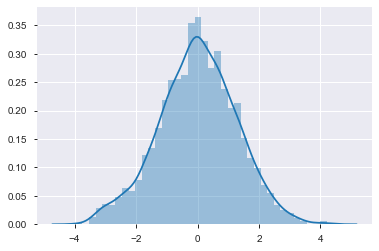

In [300]:
residuals=train_y-train_pred

import seaborn as sns

sns.distplot(residuals)

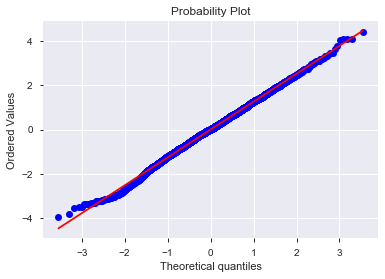

In [301]:
from scipy import stats
import pylab

stats.probplot(residuals,dist='norm',plot=pylab)
pylab.show()

In [302]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

**decision Tree**

In [303]:
test_x1 = test_x.copy()
train_x1 = train_x.copy()
train_x1

,const,carbought_1,card2_2,card2_3,card2_4,card2benefit_3,card_2,card_3,card_4,card_5,...,equipten,forward_1,gender_1,jobcat_6,othdebt,polparty_1,polview_2,polview_6,reason_2,voice_1
741,1.0,1,1,0,0,1,0,0,0,0,...,873.80,0,1,0,1.441566,0,0,0,0,0
3320,1.0,1,0,1,0,0,1,0,0,0,...,0.00,0,1,0,0.540000,0,0,0,1,0
4903,1.0,1,0,0,1,0,0,0,0,0,...,1241.85,1,0,0,2.215950,0,0,0,0,1
554,1.0,1,0,1,0,0,1,0,0,0,...,0.00,0,1,0,0.972160,0,0,0,0,0
3819,1.0,0,0,1,0,0,1,0,0,0,...,0.00,0,0,0,6.883508,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681,1.0,0,0,0,1,0,1,0,0,0,...,0.00,1,0,1,1.090723,1,1,0,0,1
962,1.0,1,0,1,0,1,0,0,1,0,...,1462.10,0,1,0,2.979255,1,0,1,0,0
135,1.0,1,0,0,0,1,0,0,1,0,...,1144.75,0,0,0,1.088622,0,0,0,0,0
4764,1.0,0,1,0,0,1,0,0,1,0,...,487.70,0,1,0,1.103760,0,0,0,0,0


In [304]:
test_x1 = test_x1.drop(['const'], axis = 1)
train_x1 = train_x1.drop(['const'], axis = 1)

In [305]:
test_x1

,carbought_1,card2_2,card2_3,card2_4,card2benefit_3,card_2,card_3,card_4,card_5,cardmon,...,equipten,forward_1,gender_1,jobcat_6,othdebt,polparty_1,polview_2,polview_6,reason_2,voice_1
500,0,0,1,0,0,1,0,0,0,11.75,...,0.0,1,1,0,0.660977,0,0,0,0,0
2867,0,1,0,0,1,0,1,0,0,4.25,...,0.0,0,1,0,0.954720,1,0,0,0,1
2375,0,0,1,0,0,0,0,0,0,14.00,...,0.0,1,1,0,4.629768,0,0,0,1,1
2906,1,0,0,1,1,0,0,0,0,23.75,...,0.0,1,1,0,0.409200,0,0,0,0,0
4223,0,0,0,1,0,0,1,0,0,40.25,...,0.0,1,1,0,11.640996,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615,0,1,0,0,0,0,0,1,0,19.25,...,0.0,0,0,0,2.286270,0,1,0,0,0
4161,0,0,0,0,1,0,0,1,0,22.50,...,0.0,1,0,0,5.257590,0,0,0,0,1
3706,1,0,0,0,0,0,1,0,0,14.25,...,0.0,0,0,0,4.301220,0,1,0,0,0
3576,1,1,0,0,0,0,0,1,0,13.00,...,954.0,1,1,0,3.205740,0,0,0,0,0


In [306]:
Linear = LinearRegression()
Linear.fit(train_x1, train_y)
pred_y_lin = Linear.predict(test_x1)
acc_linear=round( Linear.score(train_x1, train_y) * 100, 2)
print ('score:'+str(acc_linear) + ' percent')

score:30.96 percent


In [307]:
dt=DecisionTreeRegressor(criterion='mse',max_depth=10,min_samples_split=2, min_samples_leaf=1)
dt.fit(train_x1, train_y)
y_pred_dt= dt.predict(test_x1)
acc_dt = round( dt.score(train_x1, train_y) * 100, 2)
print (str(acc_dt) + ' percent')

55.3 percent


In [308]:
dt1 = RandomForestRegressor(n_estimators=10, max_depth=5,min_samples_split=2,min_samples_leaf=1)
dt1.fit(train_x1, train_y)
y_pred_rf=dt1.predict(test_x1)
acc_rf= round(dt1.score(train_x1, train_y) * 100, 2)
print ("Accuracy: %i %% \n"%acc_rf)

Accuracy: 25 % 



# Decision tree has highest accuracy.

# Predicting Sales(using decision tree)

In [309]:
data_dt=data_rf[feature_columns]

#data_dt=sm.add_constant(data_rf)

In [310]:
len(list(feature_columns))

25

In [311]:
len(list(data_dt.columns))

25

# Final prediction on test file

In [312]:
from scipy.special import boxcox, inv_boxcox

pred_total_spend=inv_boxcox(dt.predict(data_dt),fitted_lambda)
pred_total_spend=pd.DataFrame(pred_total_spend.tolist())
pred_total_spend.columns = ['pred_total_spend']

In [313]:
pred_total_spend

,pred_total_spend
0,386.800442
1,456.401491
2,344.305805
3,331.159511
4,289.121358
...,...
4995,1213.733188
4996,556.109272
4997,814.765540
4998,752.950000


# Merging data with the final prediction

In [314]:
final_file = pd.concat([credit, pred_total_spend], axis=1)


In [315]:
final_file.head()

,region,townsize,gender,age,agecat,birthmonth,ed,edcat,jobcat,union,...,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03,totalspend,pred_total_spend
0,1,2,1,20,2,September,15,3,1,1,...,0,1,1,0,0,0,1,0,149.46,386.800442
1,5,5,0,22,2,May,17,4,2,0,...,1,1,1,1,1,0,0,0,77.54,456.401491
2,3,4,1,67,6,June,14,2,2,0,...,0,0,0,0,1,0,0,0,359.97,344.305805
3,4,3,0,23,2,May,16,3,2,0,...,1,1,1,0,1,1,0,0,359.41,331.159511
4,2,2,0,26,3,July,16,3,2,0,...,1,0,1,0,0,0,1,0,507.83,289.121358
